## Solving the XOR problem with the ANNarchy-NEAT extension

In this Notebook we will use the ANNarchy-NEAT extension to generate spiking neural networks to solve the XOR problem. In XOR, we have two inputs that can each be 0 or 1, and the output is 1 only when one of the inputs is 1 (but not both). So, XOR gives the following outputs:

    0 XOR 0  = 0
    0 XOR 1  = 1
    1 XOR 0  = 1
    1 XOR 1  = 0



First we will import ANNarchy to simulate the spiking neural network.

In [1]:
%pip install ANNarchy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


We now import the additional code where the NEAT algorithms is implemented. This is taken from the repository where the code of the Baladron et al. (2025) paper is stored.

In [2]:
import requests

url = "https://github.com/bastianloyola/NEAT-ANNarchy/raw/refs/heads/main/neatannarchy.py"
file_name = "neatannarchy.py"
response = requests.get(url)

if response.status_code == 200:
    with open(file_name, "wb") as file:
        file.write(response.content)
    print(f"File succesfully downloaded and stored as '{file_name}'.")
else:
    print(f"Error while downloading the file: {response.status_code}")


File succesfully downloaded and stored as 'neatannarchy.py'.


We now import the necessary libraries including ANNarchy and the necesary scientific code.

In [3]:
from ANNarchy import *
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import scipy.sparse

ANNarchy 4.7 (4.7.3) on linux (posix).


# Neuron model
We now define the neuron model to use. We then copy the model definition to a file named neuronmodel.py.

For more information regarding how to define neuron modesl in ANNarchy go to https://annarchy.readthedocs.io/API/Neuron.html


In [4]:
%%writefile neuronmodel.py

from ANNarchy import *

LIF = Neuron(  #I = 75
    parameters = """
    tau = 50.0 : population
    I = 0.0
    tau_I = 10.0 : population
    """,
    equations = """
    tau * dv/dt = -v + g_exc - g_inh + (I-65) : init=0
    tau_I * dg_exc/dt = -g_exc
    tau_I * dg_inh/dt = -g_inh
    """,
    spike = "v >= -40.0",
    reset = "v = -65"
)

Overwriting neuronmodel.py


# Fitness function

---
Next, we define the fitness function which includes the coding scheme for the input and outputs. The fitness function must return a value of the quality of the network. The NEAT algorithm will search for networks that maximize this value.



For the XOR problem we define the 4 possible input combinations and then determine the network output for each. The return value is equal to the number of input pattern with the proper output.

There are 2 input neurons, one for each input variable. If a variable is 1 then its input current (I) is set to 15. For each input pattern, the network is simulated for 10ms.


In [5]:
%%writefile fitness.py

from ANNarchy import *
import numpy as np

def xor(pop,Monitor,input_index,output_index,inputWeights, genome_id):
    Monitor.reset()
    entradas = [(0, 0), (0, 1), (1, 0), (1, 1)]
    fitness = 0
    for entrada in entradas:
        for i, val in zip(input_index, entrada):
            if val == 1:
                pop[int(i)].I = 15.1*inputWeights[i]
            else:
                pop[int(i)].I = 0
        simulate(10.0)
        spikes = Monitor.get('spike')
        #print("spikes: ",spikes)
        #Get the output
        output = []
        for i in output_index:
            output.append(sum(spikes[i]))
        #print("output: ",output)
        decode_output = 0
        if output[0] <= output[1]:
            decode_output = 1

        pop.reset()
        Monitor.reset()
        #comparar las entradas y la salida esperada con el output
        if entrada[0] ^ entrada[1] == decode_output:
            fitness += 1
    return fitness

Overwriting fitness.py


# Hyperparameters

We will now create a folder where we will store all the required configuration files.\

In [6]:
%mkdir -p config

Each configuration file must define the following parameters:

- keep: percentage of the population that will remain after the elimination process
- threshold: Threshold for the difference between an individual and the representative of a species to incorporate them into a species
- interSpecieRate: probabilidad de generar un entrecruzamiento entre individuos de distintas especies
- noCrossoverOff: probability of a crossover between individuals of different species.
- probabilityWeightMutated: Probability that a weight is perturbed.
- probabilityAddNodeSmall: Probability that a node is created for a small network
- probabilityAddLink_small: Probability that a connection is created for a small network
- probabilityAddNodeLarge: Probability that a node is created for a large network
- probabilityAddLink_Large: Probability that a connection is created for a large network
- c1, c2 y c3: Factors used during the speciation
- largeSize: Number of neurons needed to consider a network as large
- numberInputs: Number of input neurons
- numberOutputs: Number of output neurons
- n_max: Maximum number of neurons a network
- learningRate: Maximum value of a weight perturbation
- inputWeights: Values used to modulate the input values while computing the fitness.
- weightsRange: Initial possible range of values for the initial random weights(n < m).

In [7]:
%%writefile config/config.cfg
keep=0.49
threshold=3.251
interSpeciesRate=0.0001
noCrossoverOff=0.159
probabilityWeightMutated=0.821
probabilityAddNodeSmall=0.026
probabilityAddLink_small=0.038
probabilityAddNodeLarge=0.223
probabilityAddLink_Large=0.154
c1=1.188
c2=1.09
c3=0.481
largeSize=8
numberInputs=2
numberOutputs=2
n_max=100
learningRate=10
inputWeights=110,150
weightsRange=100,110

Writing config/config.cfg


We still need to define a few more parameters.

- func: Name of the fitness function
- neuron_model: Name of the neuron model
- process: Amount of parallel processes used while computing the fitness values.
- evolutions: Amount of iterations of the NEAT main loop
- population: Amount of genomes

In [101]:
func = "xor"
neuron_model = "LIF"
process = 10
evolutions = 10
population = 100

In [102]:
trial = 1

Finally we execute NEAT and obtain the fitness of the best network found.

In [103]:
from neatannarchy import runNEAT, fitness_value, plot_information

In [104]:
runNEAT(trial, func, neuron_model, process, evolutions, population)

In [105]:
print("Fitness value: ", fitness_value(trial))

Fitness value:  4.0


Data saved in results/trial-1/output.json


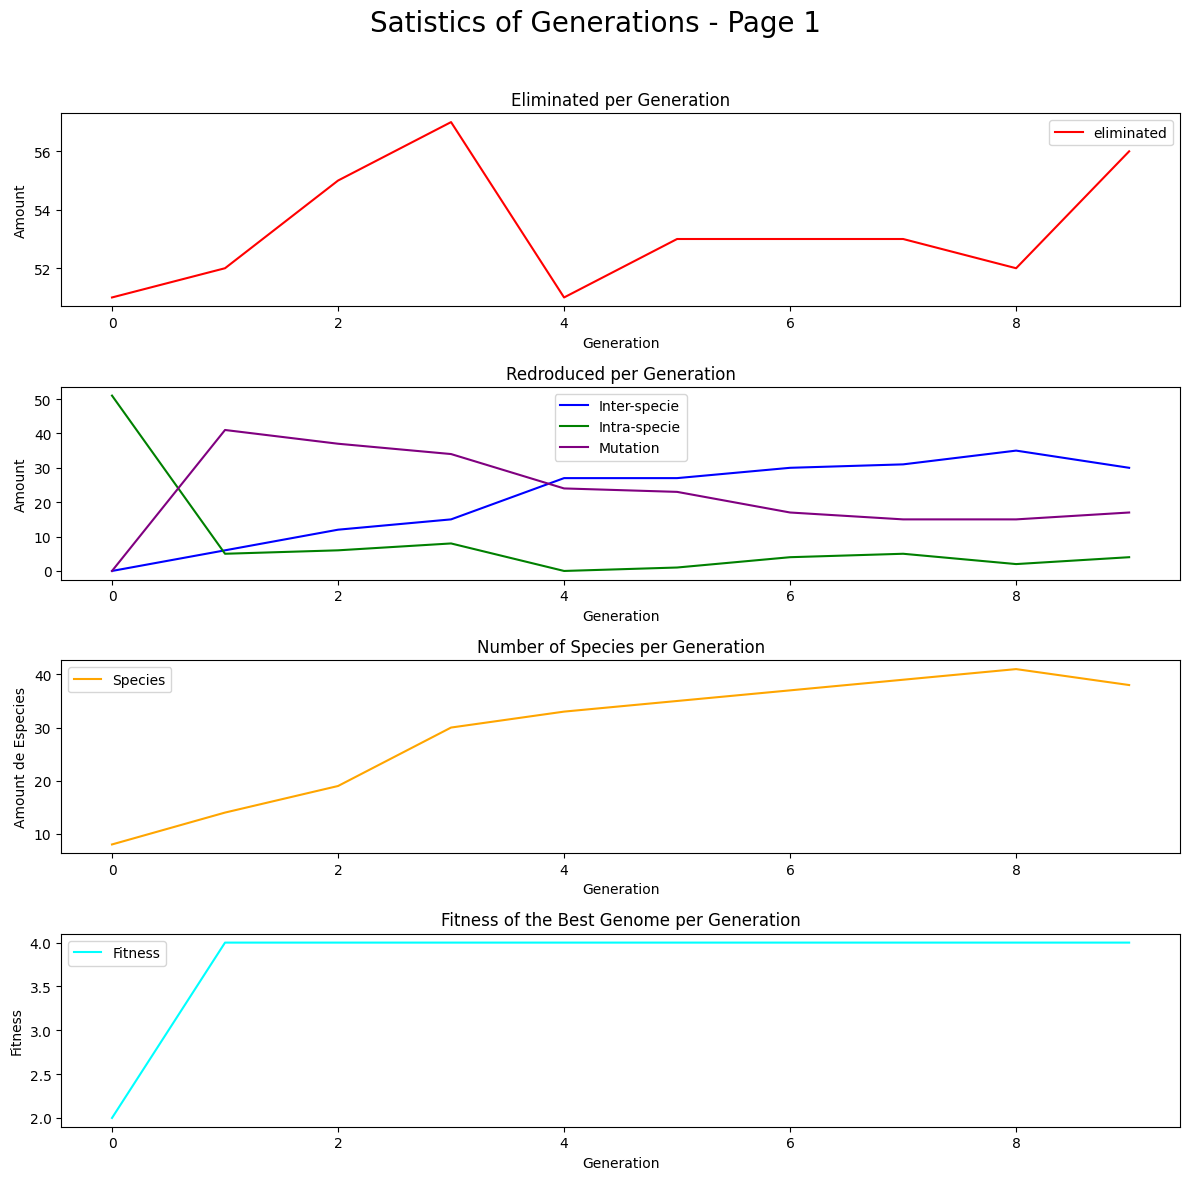

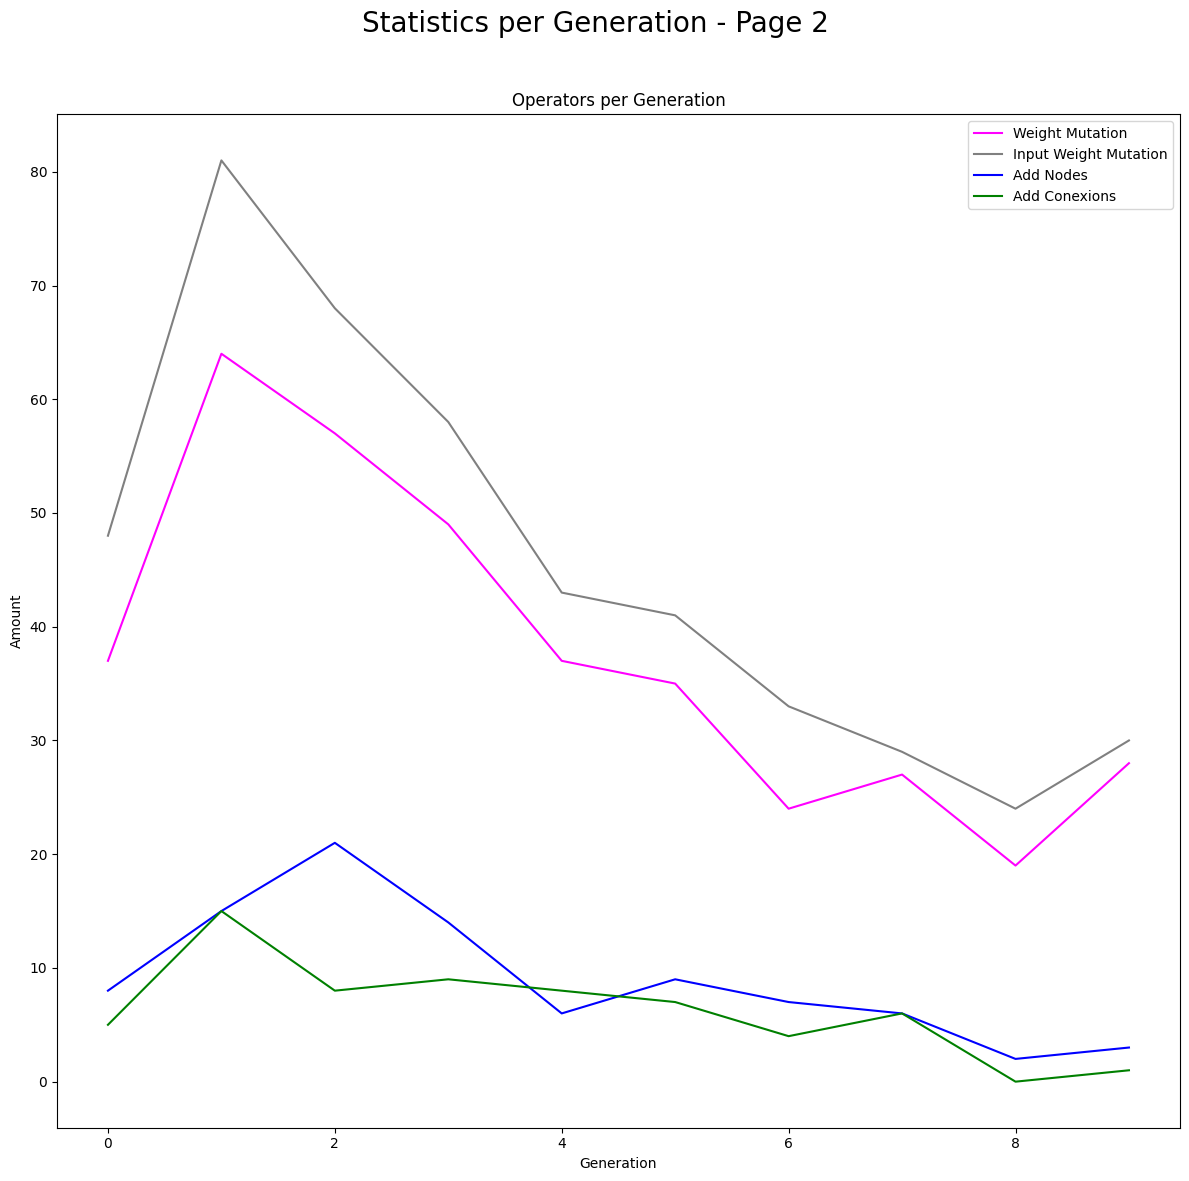

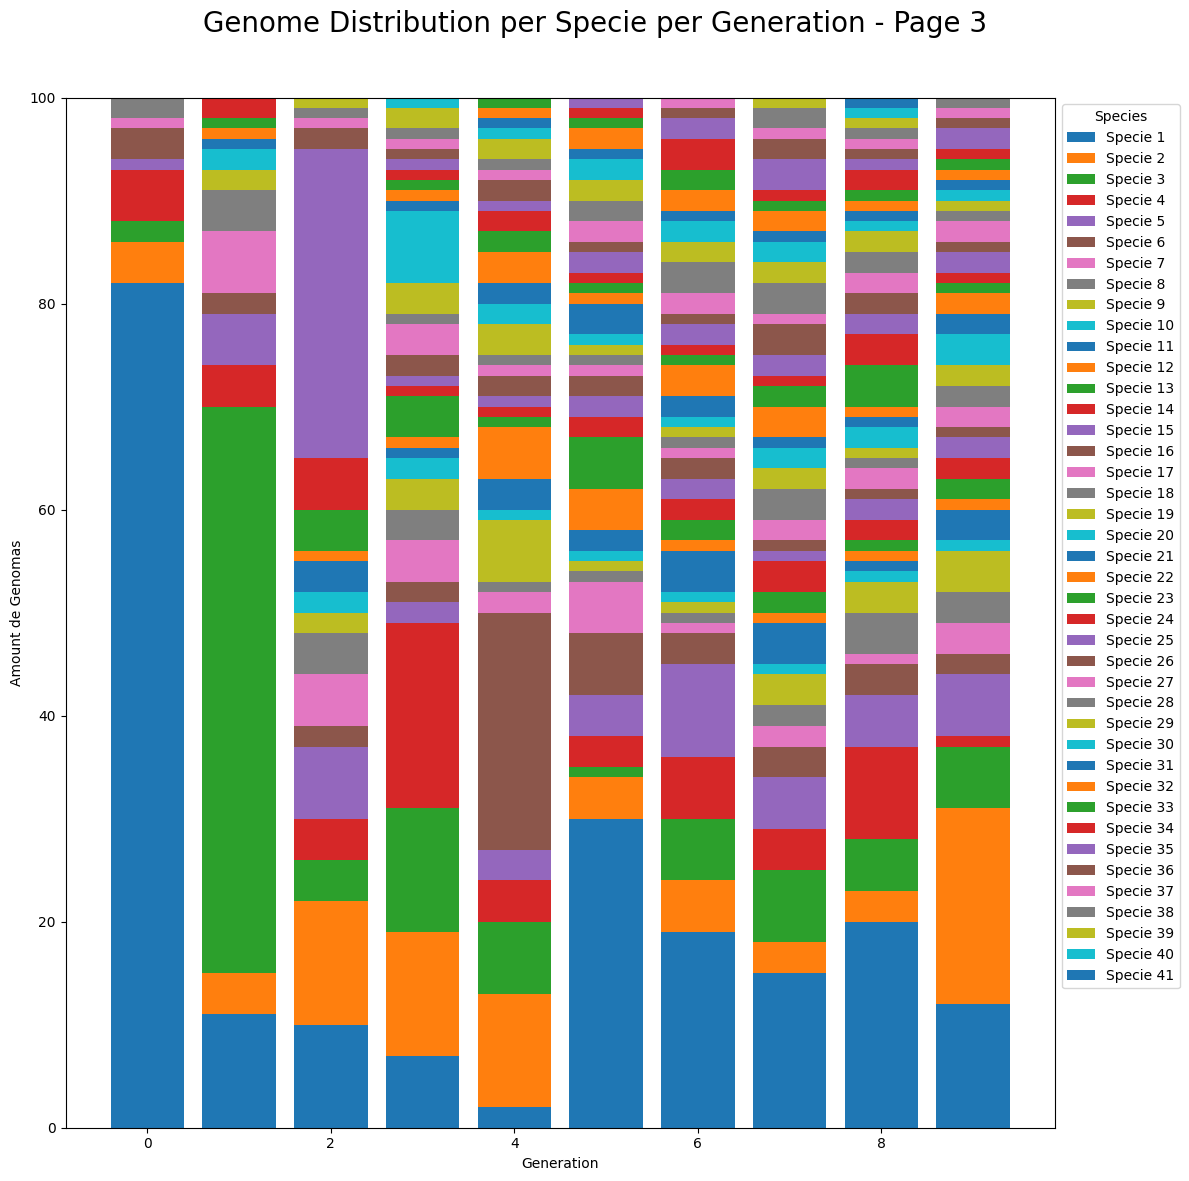

In [106]:
plot_information(trial)